<a href="https://colab.research.google.com/github/androbaza/IP-algos/blob/main/3_Separable_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from imageio import imread
from skimage.transform import resize
from scipy.ndimage.filters import convolve
from numpy.linalg import svd, matrix_rank

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(512, 512)


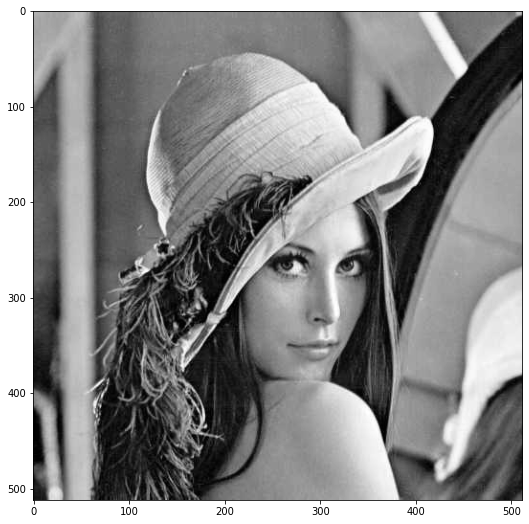

In [5]:
im = imread("/content/drive/MyDrive/samples/lena.jpg", pilmode="L")
im = im.astype(np.float32) / 255.

print(im.shape)

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(im, cmap=plt.cm.gray)
plt.show()

def gauss_filter(size=5, sigma=1):
    """
    creates gaussian kernel with a given size and sigma
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()

## Task 3 - Separable Filters
A 2D convolution filter $C \in \mathbb{R}^{m \times n}$ is called **separable**, if it is possible to decompose it into two 1D convolution filters $D_1 \in \mathbb{R}^{m \times 1}$ and $D_2 \in \mathbb{R}^{1 \times n}$ such that

$$
\begin{align}
  \forall I \in \mathbb{R}^{k \times l}: \quad I * C = (I * D_1) * D_2
\end{align} \,.
$$

Since the convolution is associative, this can be expressed in closed form:
$$
C = D_1 * D_2 \,.
$$

And since $D_1$ and $D_2$ are column and row vectors, the condition is equivalent to:

$$
C = D_1 D_2 \,.
$$

- Given a matrix $C$, how can we compute suitable vectors $D_1$ and $D_2$? How can you decide if a matrix $C$ is separable?
- Compare the runtime of <code>scipy.ndimage.filters.convolve</code> for separable and non-separable filters of different sizes. Visualize the runtimes in a plot!
- **Challenge yourself**: Modify your function from task 1 so that it checks if the given 2D filter is separable and if it is the case, than it should separate the filter and perform two 1D convolutions. Compare now the runtime of your new function for separable and non-separable filters.

### Filter Separation

In [61]:
def check_filter(mask):
    """ 
    Returns True if mask is decomposable and False otherwise.
    """
    return np.linalg.matrix_rank(mask) == 1


def decompose(mask):
    """
        Decomposes mask in two vectors.
        Hint:
            Singular Value Decomposition
            https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    """
    UnArr, Singular_values, D2 = np.linalg.svd(mask)
    
    D1 = UnArr[:, :Singular_values.shape[0]] * Singular_values
    return D1, D2

The D1 is derived by multiplying the first unitary matrix by the singular values vector. 

In [62]:
# Construct box filter
size = 5
B = np.ones((size, size), dtype=np.float32) / size**2

print("Filter: \n", B)
print("\nIs decomposable:", check_filter(B))
B1, B2 = decompose(B)
print("\nDecomposed Vectors:", B1, B2, sep="\n\n")
print("\nReconstructed Filter:\n", np.dot(B1, B2))
print()


# Create a Gaussian filter mask, which is separable.
H = gauss_filter(size)

print("=" * 30)
print("\nFilter: \n", H)
print("\nIs decomposable:", check_filter(H))
H1, H2 = decompose(H)
print("\nDecomposed Vectors", H1, H2, sep="\n\n")
print("\nReconstructed Filter:\n", np.dot(H1, H2))

Filter: 
 [[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]

Is decomposable: True
5

Decomposed Vectors:

[[-8.9442722e-02  2.2204459e-17 -0.0000000e+00 -0.0000000e+00
  -0.0000000e+00]
 [-8.9442722e-02 -5.5511148e-18 -0.0000000e+00 -0.0000000e+00
  -0.0000000e+00]
 [-8.9442722e-02 -5.5511148e-18 -0.0000000e+00 -0.0000000e+00
   0.0000000e+00]
 [-8.9442722e-02 -5.5511148e-18 -0.0000000e+00  0.0000000e+00
  -0.0000000e+00]
 [-8.9442722e-02 -5.5511148e-18  0.0000000e+00 -0.0000000e+00
  -0.0000000e+00]]

[[-0.4472136  -0.4472136  -0.4472136  -0.4472136  -0.4472136 ]
 [ 0.8944272  -0.2236068  -0.2236068  -0.2236068  -0.2236068 ]
 [ 0.          0.         -0.57735026 -0.21132487  0.7886751 ]
 [ 0.          0.         -0.57735026  0.7886751  -0.21132487]
 [ 0.          0.8660254  -0.28867513 -0.28867513 -0.28867513]]

Reconstructed Filter:
 [[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.

### Quality Check

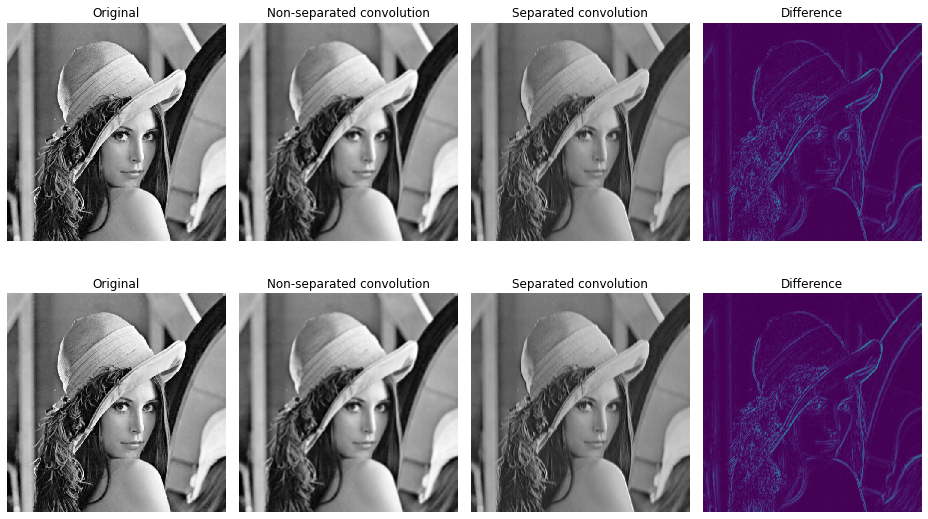

In [63]:
IB = convolve(im, B)
IB_separated = convolve(convolve(im, B1), B2)
IH = convolve(im, H)
IH_separated = convolve(convolve(im, H1), H2)


fig, axs = plt.subplots(2, 4, figsize=(13,8))

for i, (result, result_separated) in enumerate(zip([IB, IH], [IB_separated, IH_separated])):
    
    axs[i,0].imshow(im, cmap=plt.cm.gray, interpolation='nearest')
    axs[i,0].set_title('Original')

    axs[i,1].imshow(IB, cmap=plt.cm.gray, interpolation='nearest')
    axs[i,1].set_title('Non-separated convolution')

    axs[i,2].imshow(IB_separated, cmap=plt.cm.gray, interpolation='nearest')
    axs[i,2].set_title('Separated convolution')

    axs[i,3].imshow(np.abs(IB - IB_separated), interpolation='nearest', vmin=0, vmax=1)
    axs[i,3].set_title('Difference')

for ax in axs.ravel():
    ax.axis('off')

fig.tight_layout()
plt.show()

### Runtime Comparison

In [64]:
def plot_runtimes(im, sizes, conv_func):
    
    ys_sep = []
    ys_nonsep = []
    
    for size in sizes:
        sep_filter = gauss_filter(size)
        non_sep_filter = np.random.randn(size, size)
        
        t0 = time.time()
        _res = conv_func(im, sep_filter)
        t1 = time.time()
        ys_sep.append(t1 - t0)
        
        t0 = time.time()
        _res = conv_func(im, non_sep_filter)
        t1 = time.time()
        ys_nonsep.append(t1 - t0)
        
    
    fig = plt.figure(figsize=(12,8))
    
    plt.title("Runtimes of \"{}\"".format(conv_func.__name__))
    plt.xlabel("Filter Size")
    plt.ylabel("Runtime in sec")
    plt.plot(sizes, ys_sep, label="Separable Filters")
    plt.plot(sizes, ys_nonsep, label="Non-Separable Filters")
    
    plt.legend()
    plt.grid()
    
    plt.show()
    plt.close()

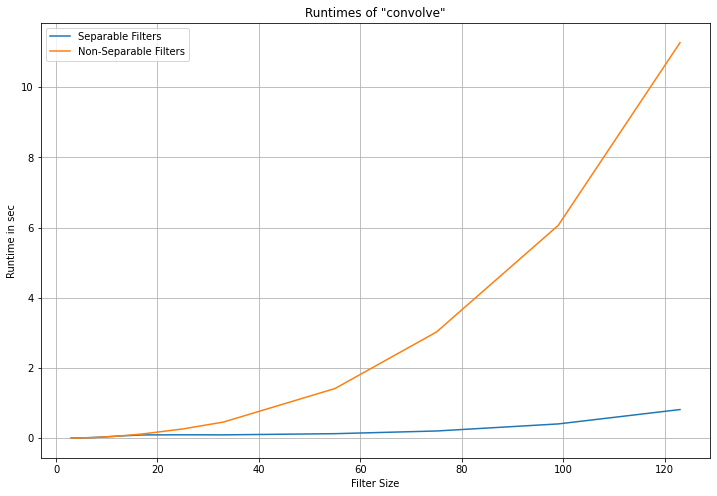

In [65]:
sizes = [3,5,7,9,13,17,25,33,55,75,99,123]
plot_runtimes(im, sizes, convolve)

The graph definetely shows that separable filters save the runtime in case of filters of size more than 20 pixels. However, as is shown in results comparison, there is a visible difference in the final image.